# (BayWheels Data)
## by (Mohamed Medhat ElDakrory)

## Preliminary Wrangling

> The Baywheel dataset is coming from Lyft website, displaying the performance of the historical trip and how the details of trips occurred, data is split into months files.

> Each cell will include a hint about what is the cell is trying to produce:

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import io
from IPython.display import Markdown, display
%matplotlib inline

In [3]:
# Selecting the main path/directory which will contain all files needed:
try:
    main_path = os.getcwd()+'\\files'
    os.mkdir(os.getcwd()+'/files')
except FileExistsError:
    os.close

In [ ]:
# This might take time to download the files for data:
# Selecting the files between 2018-01 to 2019-04 for baywheel data and downloaded to a speicifc folder:
baywheels_my = [str(i).replace("-", "") for i in pd.period_range(start='2018-01-01', end='2019-04-30', freq='M')]

for file in baywheels_my:
    url = 'https://s3.amazonaws.com/baywheels-data/' + str(file) + '-fordgobike-tripdata.csv.zip'
    folder = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(folder.content), "r") as f:
        filename = str(file) + '-fordgobike-tripdata.csv'
        f.extract(filename, main_path)

In [4]:
# Changing the directory to the path of files then loading all files to one dataframe.
os.chdir(main_path)
baywheels = pd.concat(map(pd.read_csv, os.listdir(main_path)), sort=False)

### [1] Importing & Loading:
> First started with importing the packages will be using during the project.

> Moving to set the directory that will contain files and outputs as well.

> Starting to downloading the files from the web page specifying the files needed.

> Gathering all files into one file to a data frame to work on it. 

In [25]:
# Checking and counting the duplication and empty values in the dataset:

display(Markdown("**DUPLICATION CHECK:**"))
if baywheels.duplicated().sum() == 0:
    print("There are no duplicated values")
else:
    print("The duplicated values are")
    print(baywheels.duplicated().sum())
 
print("-------------------------------------")
display(Markdown("**NULL/Empty fields CHECK:**"))
if baywheels.isnull().sum().any():
    print("The NULL values are:")
    print(baywheels.isnull().sum()[baywheels.isnull().sum().values > 0])
else:
    print("There are no null/empty values");

**DUPLICATION CHECK:**

There are no duplicated values
-------------------------------------


**NULL/Empty fields CHECK:**

The NULL values are:
start_station_id      12501
start_station_name    12501
end_station_id        12501
end_station_name      12501
dtype: int64


In [5]:
# The cleaning processes on the baywheel dataset:

# Excluding the null values in start_station_id as we can not determine the accurate specification for these rides:
baywheels = baywheels[baywheels['start_station_id'].notnull()]

# Starting to re-assign the datatypes to each column in the dataset to reduce the dataset size and enhance the performance as well:

start_memory = baywheels.memory_usage().sum() / 1024**2
print("Memory usage of baywheels dataframe is :",start_memory," MB")

# Convert the columns which are datetime type:
datetime_variables = ['start_time', 'end_time']
baywheels['start_time'] = pd.to_datetime(baywheels['start_time'], format='%Y%m%d %H:%M:%S.%f')
baywheels['end_time'] = pd.to_datetime(baywheels['end_time'], format='%Y%m%d %H:%M:%S.%f')
baywheels['year_month'] = pd.to_datetime(baywheels['start_time']).dt.to_period('M')

# Checking that duration_sec column is calculated right by performing a calculation on the start and end time, then
# excluding the rides which not calculated right.
duration_check = pd.DataFrame(dict(duration_v1 = baywheels['duration_sec'] - (baywheels['end_time'] - baywheels['start_time']).astype('timedelta64[s]')))
duration_check[duration_check['duration_v1'] != 0]
baywheels.drop(duration_check[duration_check['duration_v1'] != 0].index, inplace=True)

# Convert the columns which are categorical type:
cat_variables = ['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'bike_id', 'user_type', 'bike_share_for_all_trip']
for cat in cat_variables:
    baywheels[cat] = baywheels[cat].astype('category')

# Convert the columns which are Numerical type:    
num_variables = ['duration_sec', 'start_station_latitude', 'start_station_longitude','end_station_latitude', 'end_station_longitude']
for col in num_variables:

#re-assigning the datatypes for numerical to the appropriate type to reduce memory usage:
    IsInt = False
    mx = baywheels[col].max()
    mn = baywheels[col].min()
    # Make Integer/unsigned Integer data types
    if IsInt:
        if mn >= 0:
            if mx < 255:
                baywheels[col] = baywheels[col].astype(np.uint8)
            elif mx < 65535:
                baywheels[col] = baywheels[col].astype(np.uint16)
            elif mx < 4294967295:
                baywheels[col] = baywheels[col].astype(np.uint32)
            else:
                baywheels[col] = baywheels[col].astype(np.uint64)
        else:
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                baywheels[col] = baywheels[col].astype(np.int8)
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                baywheels[col] = baywheels[col].astype(np.int16)
            elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                baywheels[col] = baywheels[col].astype(np.int32)
            elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                baywheels[col] = baywheels[col].astype(np.int64)    
            
# Make float datatypes 32 bit
    else:
        baywheels[col] = baywheels[col].astype(np.float32)

    
# Print final result after cleaning the dataset:
print("___MEMORY USAGE AFTER COMPLETION:___")
end_memory = baywheels.memory_usage().sum() / 1024**2 
print("Memory usage is: ",end_memory," MB")
print("This is ",100*end_memory/start_memory,"% of the initial size")

Memory usage of baywheels dataframe is : 659.212890625  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  329.99629974365234  MB
This is  50.05913938223853 % of the initial size


### [2] Cleaning & Wrangling:
> After Checking the duplicated values in the data frame, it seems no duplicates data there.

> After checking the null values and specifying the variables will delete the specified rows given I can not determine the exact values for this observation and as it's less than 0.5% of data will ignore it.

> Starting to re-assign the datatypes as most of the text formats be an object and consume a high memory usage, also the number formats be assigned to the highest bytes so reducing the int64 to int32 will be faster to process into the notebook and to assign each variable to their specified type like DateTime, int/float and category, etc.


### What is the structure of your dataset?

> The dataset is a combination of 14 files combined horizontally from 2018-01 to 2019-04.

> There are 12,501 observations with NULL values in [station_id, station_name] which reference to invalid trips.

> Before-Cleaning: The dataset shape is 2,734,624 rows and 14 columns, with different data-types as [object, float64, int64].    
  After-Cleaning: The dataset shape is 2,722,124 rows and 14 columns, with different data-types as [category, float32, datetime].
 
> There are no duplicated values, so each row represents a unique trip detail.
 
### What is/are the main feature(s) of interest in your dataset?

> The trends/seasonality of the trips.

> The summary of trip duration across the time-series.

> Who are the top performance bikers and what they do? 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Trends/seasonality: The number of trips and Hours spend across the time-series trends.

> trip duration: duration sec gives us a view of avg duration and how the duration is distributed when the duration is affected.

> Top bikers: How many trips, Hours, and trips per hour they do Can classify the bikers based on performance.

## Univariate Exploration


**The overall view of trip duration in hour:**

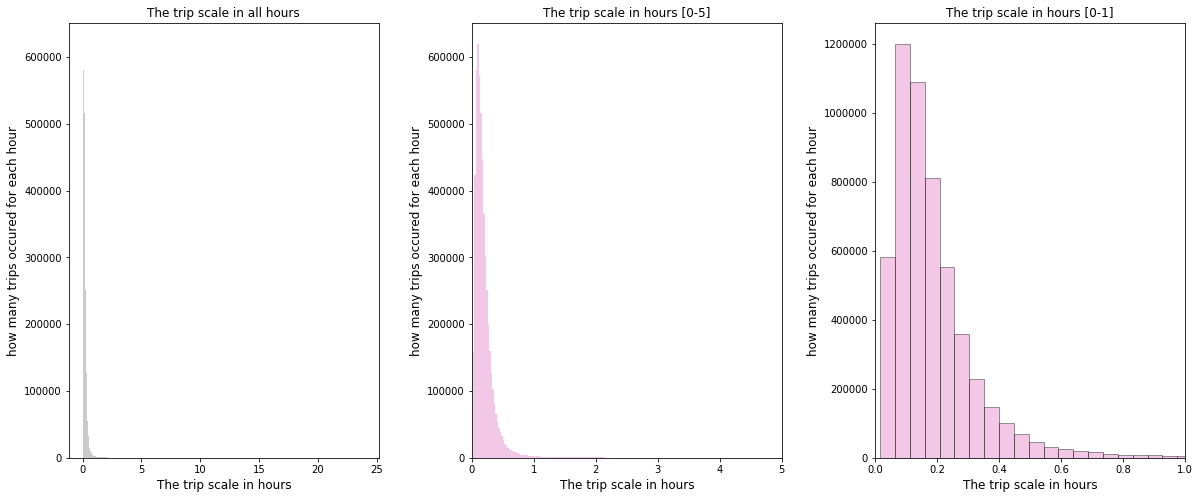

In [46]:
# Looking into the distribution of trip duration to understand how is the trips is distributed:
display(Markdown("**The overall view of trip duration in hour:**"))

fig, ax = plt.subplots(ncols=3, figsize=(20,8))

sns.distplot(baywheels['duration_sec']/3600, color=sns.color_palette()[7], ax=ax[0], bins=1000, kde = False)
ax[0].set_title("The trip scale in all hours", fontsize=12)
ax[0].set_xlabel("The trip scale in hours", fontsize=12)
ax[0].set_ylabel("how many trips occured for each hour", fontsize=12)

sns.distplot(baywheels['duration_sec']/3600, color=sns.color_palette()[6],  ax=ax[1], bins= 1000, kde = False)
ax[1].set_title("The trip scale in hours [0-5]", fontsize=12)
ax[1].set_xlabel("The trip scale in hours", fontsize=12)
ax[1].set_ylabel("how many trips occured for each hour", fontsize=12)
ax[1].set(xlim= (0,5));

sns.distplot(baywheels['duration_sec']/3600, color=sns.color_palette()[6], ax=ax[2], bins= 500, kde = False, hist_kws=dict(edgecolor="k"))
ax[2].set_title("The trip scale in hours [0-1]", fontsize=12)
ax[2].set_xlabel("The trip scale in hours", fontsize=12)
ax[2].set_ylabel("how many trips occured for each hour", fontsize=12)
ax[2].set(xlim= (0,1))

plt.subplots_adjust(wspace=.3);

As the first step will look at the distribution of trips across the hours is their concentration at specific hours, are their hours might be considered as un-realistic or outliers.

The distribution of the trips across the hours milestone shows a huge concentration at the beginning which is close to the normal as it's hard to see a trip for more than 10-20 hours, Given more than 99% of the trips occur for the ride below the 3 hours.

I will choose the 5 hours as the last milestone and filter the data based on it forward.

In [39]:
# Looking at the hours shares to understand where is the concentration of trips. 
display(Markdown("**How is the shared hours looks liks?**"))
round(pd.DataFrame(
        pd.pivot_table(
            data = pd.DataFrame(
                dict(year_month = baywheels['year_month'], duration_hour = round(baywheels['duration_sec']/3600))),
                   index = 'duration_hour', values = 'year_month', aggfunc='count')['year_month']/baywheels.shape[0])*100.00,2).transpose()


**How is the shared hours looks liks?**

duration_hour,0.0,1.0,2.0,3.0,4.0,5.0
year_month,95.3,3.96,0.44,0.17,0.08,0.05


In [29]:
# Excluding the trips above 5 hours, as it's suspicious for a long trip to be more than 5 hours.
baywheels = baywheels[round(baywheels['duration_sec']/3600) <= 5]

**The month-year view of trip duration in hour:**

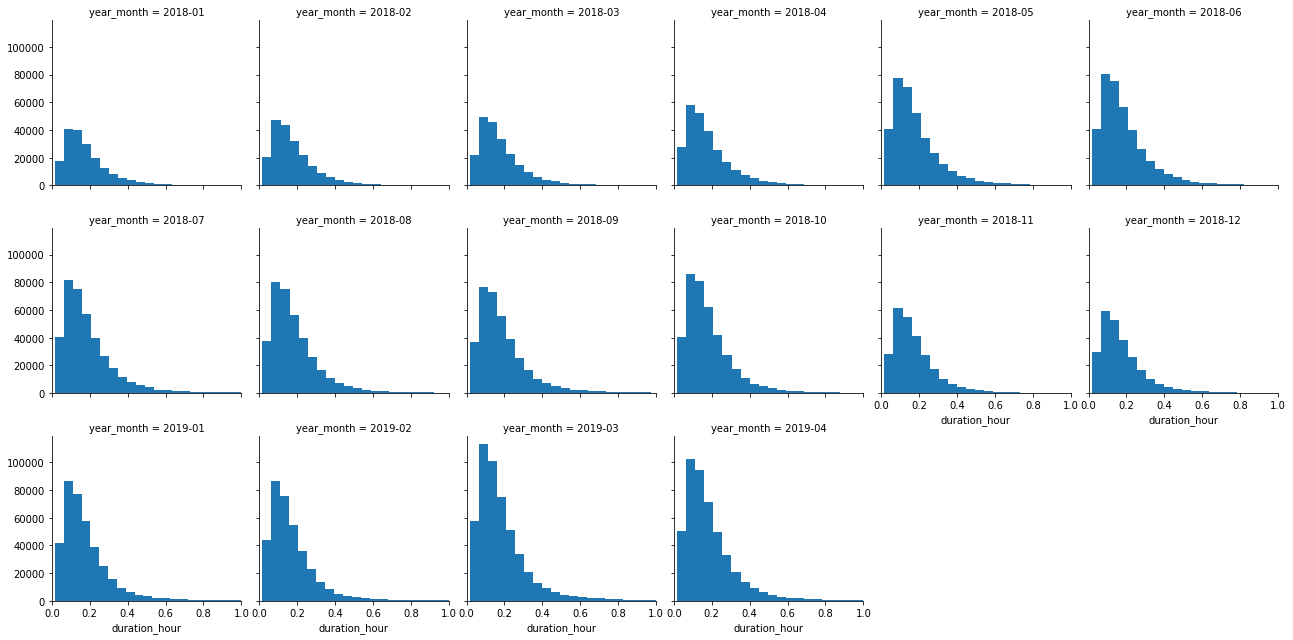

In [49]:
# The month-year distribution of the duration across all times is there any changes in specific month or year.
display(Markdown("**The month-year view of trip duration in hour:**"))

ym = sns.FacetGrid(data = pd.DataFrame(dict(year_month = baywheels['year_month'], duration_hour = baywheels['duration_sec']/3600))
                   , col= 'year_month', margin_titles=True, col_wrap=6)
ym.map(plt.hist, "duration_hour", bins=500)
plt.xlim(0,1);

After excluding the trips with more than 5 hours, will look if these trips are happening in no specific time frame not affected by a specific month or year as an example, showing after plotting that all month across all years shows the same distribution of concentration of hours below the 3 hours.

So no need for more action regarding this observation across year/month here.

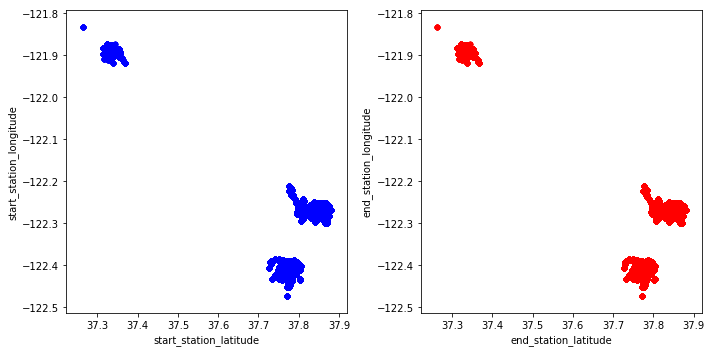

In [47]:
# Looking at the location if there any locations are weird to be displayed:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
baywheels[['start_station_latitude', 'start_station_longitude']].plot.scatter(x='start_station_latitude', y='start_station_longitude', c='blue', ax=ax[0])
baywheels[['end_station_latitude', 'end_station_longitude']].plot.scatter(x='end_station_latitude', y='end_station_longitude', c='red', ax=ax[1])
fig.tight_layout();

- Looking at the location outliers by displaying the longitude and latitude as both tend to have values close to each other if we are considering a specific area or country, so it hard to see a latitude with 37 value vs 0 value this is not normal.

- Finding that majority of both latitude and longitude are clustering groups of concentration which gives us that all points tend to be close and realistic, just a few points with zero values will be considered as wrong-info and will be deleted.

In [32]:
# Then looking into the locations itself as tabular data, we witness that there are some location looks weird:

for i in ['start_station_latitude', 'start_station_longitude', 'end_station_latitude','end_station_longitude']:
    print(pd.DataFrame(round(baywheels[i],1).value_counts()))
    
baywheels.drop(baywheels[baywheels['start_station_latitude'] == 0].index, inplace=True)
baywheels.drop(baywheels[baywheels['end_station_latitude'] == 0].index, inplace=True)

           start_station_latitude
37.799999                 2323117
37.900002                  228084
37.299999                  121360
37.700001                   41398
37.400002                    3013
0.000000                        1
             start_station_longitude
-122.400002                  1994864
-122.300003                   562934
-121.900002                   124348
-122.199997                    28180
-122.500000                     6621
-121.800003                       25
 0.000000                          1
           end_station_latitude
37.799999               2335025
37.900002                220422
37.299999                121243
37.700001                 37133
37.400002                  3132
0.000000                     18
             end_station_longitude
-122.400002                1995067
-122.300003                 558435
-121.900002                 124360
-122.199997                  32612
-122.500000                   6466
 0.000000                       

In [33]:
# Looking to the categorical columns, are they unique or some are not:
# Given that the start id or name must be the same for the station:
for i in cat_variables:
    print("The", i, "Column has ", baywheels[i].nunique(), "a unique values")

The start_station_id Column has  368 a unique values
The start_station_name Column has  387 a unique values
The end_station_id Column has  368 a unique values
The end_station_name Column has  387 a unique values
The bike_id Column has  6401 a unique values
The user_type Column has  2 a unique values
The bike_share_for_all_trip Column has  2 a unique values


> 1- First will look into is the ids/names of stations are the same for the starting and ending as well, or there are some locations not overlapping.
2- It seems that there are some stations has a typo name in both start and end station.                                      
3- Will re-assign the station which has a typo to the respective station, choosing the most station-name has more trips to be more valid.                                                                                                                   
4- Recheck again if the ids and names are matched equally.

In [34]:
#[1]
if ((baywheels['start_station_id'].unique().isin(baywheels['end_station_id'].unique()).all()) == True &
    (baywheels['start_station_name'].unique().isin(baywheels['end_station_name'].unique()).all())) == True:
    print("Station ID & Station Name are the same for start/stop station")
else:
    print("Station ID & Station Name are NOT the same for start/stop station, recheck it again")
    
    
#[2]
start = baywheels[['start_station_id', 'start_station_name']].drop_duplicates(subset=['start_station_id', 'start_station_name'])
start = start[
    start['start_station_id'].isin(
        start.groupby('start_station_id').count()[start.groupby('start_station_id').count()['start_station_name'] > 1].index)
].sort_values(by = ['start_station_id'], ascending=False)


end = baywheels[['end_station_id', 'end_station_name']].drop_duplicates(subset=['end_station_id', 'end_station_name'])
end = end[
    end['end_station_id'].isin(
        end.groupby('end_station_id').count()[end.groupby('end_station_id').count()['end_station_name'] > 1].index)
].sort_values(by = ['end_station_id'], ascending=False)


startname = baywheels[['start_station_id', 'start_station_name']].drop_duplicates(subset=['start_station_id', 'start_station_name'])
startname[
    startname['start_station_name'].isin(
        startname.groupby('start_station_name').count()[startname.groupby('start_station_name').count()['start_station_id'] > 1].index)
].sort_values(by = ['start_station_name'], ascending=False)

endname = baywheels[['end_station_id', 'end_station_name']].drop_duplicates(subset=['end_station_id', 'end_station_name'])
endname[
    endname['end_station_name'].isin(
        endname.groupby('end_station_name').count()[endname.groupby('end_station_name').count()['end_station_id'] > 1].index)
].sort_values(by = ['end_station_name'], ascending=False)

baywheels.drop(baywheels[baywheels['start_station_id'] == 385.0]['start_station_name'].index, inplace=True)
baywheels.drop(baywheels[baywheels['end_station_id'] == 385.0]['end_station_name'].index, inplace=True)


#[3]
# Merging the start-end tables for the station to choose the re-naming locations:
main = pd.merge(
    left = pd.merge(left = start, right = end, how='left', 
    left_on=['start_station_id', 'start_station_name'], 
    right_on=['end_station_id', 'end_station_name']),
         
    right = pd.pivot_table(
        baywheels[['start_station_id', 'start_station_name', 'duration_sec']], 
        index=['start_station_id', 'start_station_name'], 
        values=['duration_sec'],
        aggfunc= 'count').sort_values(by = ['start_station_id', 'duration_sec'], ascending=True),
    
    on= ['start_station_id', 'start_station_name'], how = 'left')

main['rank'] = main.groupby('start_station_id')['duration_sec'].rank(method='min', ascending=False)
display(main)

# Creating reference for the id-station_name for the typo ones:
ref = main[main['rank'] == 1][['start_station_id', 'start_station_name']].set_index('start_station_id')
ref = dict(zip(ref.index, ref.start_station_name))
display(Markdown("**The refrence table of the typo stations:**"))
display(ref)

#[4]
for i, k in ref.items():
    baywheels.loc[baywheels['start_station_id'] == i, 'start_station_name'] = k
    baywheels.loc[baywheels['end_station_id'] == i, 'end_station_name'] = k

if baywheels['start_station_id'].nunique() == baywheels['start_station_name'].nunique():
    print("All start and end ids/names are cleaned now")
else:
    print("Not All ids/names are cleaned, please recheck")

Station ID & Station Name are the same for start/stop station


,start_station_id,start_station_name,end_station_id,end_station_name,duration_sec,rank
0,364.0,China Basin St at 3rd St,364.0,China Basin St at 3rd St,3726.0,1.0
1,364.0,Mission Rock St at 3rd St,364.0,Mission Rock St at 3rd St,2499.0,2.0
2,358.0,Williams Ave at 3rd St,358.0,Williams Ave at 3rd St,226.0,1.0
3,358.0,Lane St at Van Dyke Ave,358.0,Lane St at Van Dyke Ave,35.0,2.0
4,321.0,5th at Folsom,321.0,5th at Folsom,5515.0,2.0
5,321.0,5th St at Folsom,321.0,5th St at Folsom,10821.0,1.0
6,281.0,9th St at San Fernando St,281.0,9th St at San Fernando St,1173.0,1.0
7,281.0,9th St at San Fernando,281.0,9th St at San Fernando,1113.0,2.0
8,280.0,San Fernando St at 7th St,280.0,San Fernando St at 7th St,2558.0,2.0
9,280.0,6th St at San Fernando St (Temporary Location),280.0,6th St at San Fernando St (Temporary Location),2243.0,3.0


The refrence table of the typo stations


{364.0: 'China Basin St at 3rd St',
 358.0: 'Williams Ave at 3rd St',
 321.0: '5th St at Folsom',
 281.0: '9th St at San Fernando St',
 280.0: 'San Fernando at 7th St',
 272.0: 'Woolsey St at Sacramento St',
 234.0: 'Fruitvale Ave at International Blvd',
 233.0: '12th St at 4th Ave',
 221.0: '6th Ave at E 12th St (Temporary Location)',
 212.0: 'Mosswood Park',
 208.0: 'S. 4th St at San Carlos St',
 205.0: 'Miles Ave at Cavour St',
 192.0: '37th St at West St',
 173.0: 'Shattuck Ave at 55th St',
 101.0: '15th St at Potrero Ave'}

All start and end ids/names are cleaned now


- After seeing typo in some station names, Will get the id and station names which have the typo issue and start to map the stations with typo with the most name used to this station,
- this happened in both start and end stations it might be a data entry issue.



### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Duration_sec: This variable has unlogical observations as the distribution show a high right-skewed trend due to some trips pretend to be a very long trip, as well as the distribution of year-month, given the % share of the trip.          
Transformations: will select the trips with a max 5 hours.

> (start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude) these columns has a value outside the range of long/lat cooridantes with 0 values.                                                       
Transformations: it's very low so deleting it will not harm a big data-probation.

> (start_station_id, start_station_id, end_station_id, end_station_id) must ot be euqal as the station_id will be referenced to a station_name, some of the ids has a typo station_names.                                                      
Transformations: will replace the values with the high contribution station_names.                                          
For station_id there is only 2 ids with the same station_name, given that no a good way to verify which id is the right,       
Transformations: data will of the low contribution will be deleted to avoid duplication of variables.

> (bike_id, user_type, and bike_share_for_all_trip) has no issues of unusual points or outliers.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Duration_sec: Because it's very rare to have a day-long trip, so if the duration of the trip has high values will affect the measures performed on duration such as the average duration. 

> (start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude): The out-boundaries data impact the action decision of insight. 

> (start_station_id, start_station_id, end_station_id, end_station_id):  typo-data need to be replaced as if the variable is a categorical will be wrong to set the performance or metrics of the categorical.


## Bivariate Exploration


> 1- First will look into the trend of trips and hours across the month-year dataset, to see a difference in any month or year.

> 2- Then will look into the relation between trips and hours per user_type to understand the dependencies of user_type.

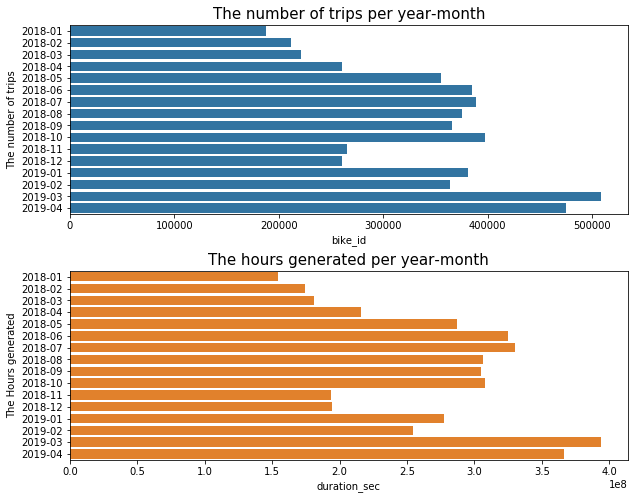

In [53]:
da = pd.pivot_table(
    baywheels[['year_month', 'duration_sec', 'bike_id']], 
    index=['year_month'], 
    values=['duration_sec', 'bike_id'],
    aggfunc= {'duration_sec': np.sum, 'bike_id': len}).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.barplot(data = da, x='bike_id', y = 'year_month', color=sns.color_palette()[0], ax=ax[0], orient="h")
ax[0].set_title("The number of trips per year-month", fontsize=15)
ax[0].set_ylabel("The number of trips", fontsize=10)
#ax[0].set_xticklabels(da['year_month'], rotation=90)

sns.barplot(data = da, x='duration_sec', y = 'year_month', color=sns.color_palette()[1], ax=ax[1], orient="h")
ax[1].set_title("The hours generated per year-month", fontsize=15)
ax[1].set_ylabel("The Hours generated", fontsize=10)
#ax[1].set_xticklabels(da['year_month'], rotation=90)

plt.subplots_adjust(hspace=.3);

- Starting to look at trends in seasonality by looking at the trips and hours trends across the year-month, do the trips or hours increased or decreased in some months or are the trips and hours overlap in some months or year.

- Showing that the trips and hours have the same trend across year/months.
- Trips and hours are increasing in the summer and go down in winter, which is close to the normal as riding the bikes it might seem hard during winter weather against the summer.
- Also, there is a huge increase in the next year months vs the last one, given us a growth perspective and predict that after 2019-05 will witness an increase in trips and hours.

The relationship between trips and hours per user_type:


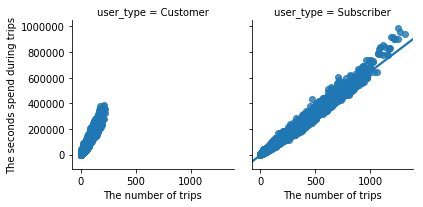

In [36]:
print("The relationship between trips and hours per user_type:")
g = sns.FacetGrid(data = pd.pivot_table(
        baywheels[['bike_id', 'duration_sec', 'user_type', 'start_station_id']], 
        index=['bike_id', 'user_type'], 
        values=['duration_sec', 'bike_id'],
        aggfunc= {'duration_sec': np.sum, 'start_station_id': len}).reset_index('user_type'), 
                  col='user_type', col_wrap=2,margin_titles=True )
(g.map(sns.regplot, 'start_station_id', 'duration_sec'))\
.set_xlabels("The number of trips")\
.set_ylabels("The seconds spend during trips");

- Given that trips and hours are depending on each other but while looking at them splitting by user type to see is the subscriber or the customer shows a different view.

- Showing that the subscriber tends to do more trips and hours more than the customer.
- The customer has a limit of trips below the 300 against the subscriber which is more than 1000.
- Both have a positive relation to each other but the subscriber tends to be more linear more than the customer.
- Given the subscriber the huge contribution of trips and hours allows us to sustain more supply to these subscribers as any damage or unfulfillment of their rides will result of losing trips and hours as well.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> There is a great trending between trips and hours across the month of each year indicating that hours are increasing with trips which is close to the normality as hours is a dependant pattern of the trip itself.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> The relationship between trips and hours has a great relation in subscriber more than the customer, which indicates that as much the biker do trips, more hours will be generated whatever was the trip duration or number of trips, against for the customer user_type which increase aggressively at the beginning which indicates that customer has a high trip-duration more than the subscriber.

## Multivariate Exploration


> 1- First will look calculation metric for 2 variables per user_type to understand the trends of seasonality across the user_types:

> 2- will look into the toppers stations in start and end to search for the common toppers stations with high demand.

C:\Users\DOUHA\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\DOUHA\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


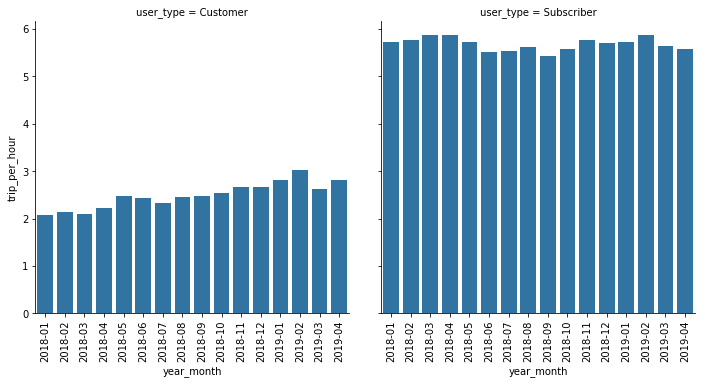

In [37]:
da2 = pd.pivot_table(
    baywheels[['year_month', 'duration_sec', 'bike_id', 'user_type']], 
    index=['year_month', 'user_type'], 
    values=['duration_sec', 'bike_id'],
    aggfunc= {'duration_sec': np.sum, 'bike_id': len}).reset_index()

da2['trip_per_hour'] = da2['bike_id'] / (da2['duration_sec']/3600)


g = sns.FacetGrid(da2, col='user_type', margin_titles=True, size=5)
(g.map(sns.barplot, 'year_month', 'trip_per_hour')).set_xticklabels(rotation=90);

- Given that trips and hours are depending and have a good relation, will start to look more about the trend vs trips per hour.
- trip per hour gives us is this rider a trip generator or not, as much the trip per hour increases this means the ride do more than trips in one hour which generate more trips in one hour against the opposite.

- The subscriber here shows a high trip per hour reach to more than 5 which almost more than double customer is doing.
- There is no big drop in any year or months, but the trip per hour for the customer seems that it increases moving forward coming from 2 trips per hour reaching 3 trips per hour which are a huge growing against the smooth or wave trend of subscribers.

- This growth might show great growth again next year to allow the customer to reach more trips per hour and become and a trip generator the same as subscribers. 

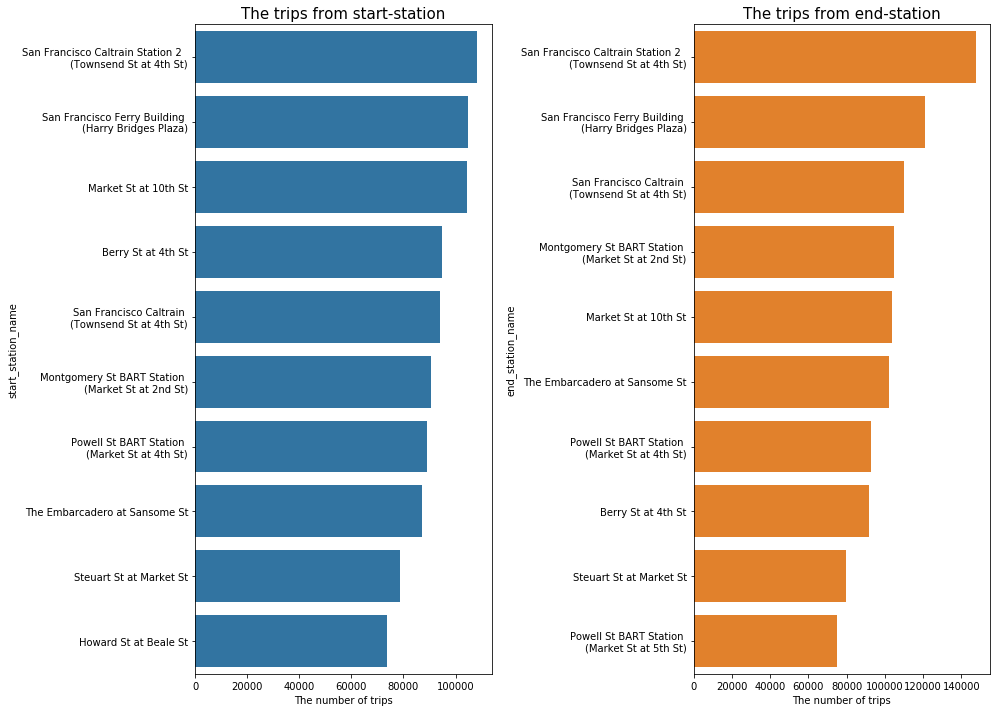

In [57]:
da3 = pd.pivot_table(
    baywheels[['start_station_name', 'duration_sec', 'bike_id']], 
    index=['start_station_name'], 
    values=['duration_sec', 'bike_id'],
    aggfunc= {'duration_sec': np.sum, 'bike_id': len}).sort_values('bike_id', ascending=False).head(10).reset_index()

da4 = pd.pivot_table(
    baywheels[['end_station_name', 'duration_sec', 'bike_id']], 
    index=['end_station_name'], 
    values=['duration_sec', 'bike_id'],
    aggfunc= {'duration_sec': np.sum, 'bike_id': len}).sort_values('bike_id', ascending=False).head(10).reset_index()

labels = [item.get_text().replace('(','\n(') for item in ax[0].get_yticklabels()]

fig, ax = plt.subplots(1, 2, figsize=(14, 10))

sns.barplot(data = da3, x='bike_id', y = da3['start_station_name'].astype('object'), color=sns.color_palette()[0], ax=ax[0])
ax[0].set_title("The trips from start-station", fontsize=15)
ax[0].set_xlabel("The number of trips", fontsize=10)
labels = [item.get_text().replace('(','\n(') for item in ax[0].get_yticklabels()]
ax[0].set_yticklabels(labels)

sns.barplot(data = da4, x='bike_id', y = da4['end_station_name'].astype('object'), color=sns.color_palette()[1], ax=ax[1])
ax[1].set_title("The trips from end-station", fontsize=15)
ax[1].set_xlabel("The number of trips", fontsize=10)
labels = [item.get_text().replace('(','\n(') for item in ax[1].get_yticklabels()]
ax[1].set_yticklabels(labels)

plt.tight_layout();

- After cleaning the station's names typo issue, looking at the top start and end stations are both overlapping with each other or not.

- It seems that most of the start stations are the end ones which generate a huge demand on these stations and require a huge supply to sustain and maintain these trips requests.

- The top stations are the hubs that can be called the generators, they generate the majority of trips so a focus will be needed to these stations.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The conversion between trips and hours give us a metric to determine whether how many trips the biker can do in one hour,
As shown the subscriber is more appealing more than customer user_type.

> Looking to the top 10 starts & end station which give us is this station is a hub zone for riders, in order to focus on.

### Were there any interesting or surprising interactions between features?

> Most of the top 10 start station are the same end ones which give us that the toppers stations are the hubs one which needs more focus.

In [50]:
# This might take time to extract the main file to be used in slide_deck file:
baywheels.to_csv('baywheels.csv', index=False)